# Gesture Recognition Module

## Notebook setup

In [ ]:
#@title Required imports
!pip install -qU gdown
!pip install -qU mediapipe

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import mediapipe as mp

import gdown
from typing import *
from zipfile import ZipFile

from tqdm.notebook import trange, tqdm

import os

In [ ]:
#@title Utils functions
from moviepy.editor import *

def show_video(frames, name="output", progress=True):
  """ Show a sequence of frames as an HTML5 video """
  out = cv.VideoWriter(name + ".mp4", cv.VideoWriter_fourcc(*"mp4v"), 20.0, (frames[0].shape[1], frames[0].shape[0]))

  for frame in tqdm(frames, desc="Generating video", disable=not progress):
    frame = cv.cvtColor(frame, cv.COLOR_RGB2BGR)
    out.write(frame)

  out.release()

  video = VideoFileClip(name + ".mp4")
  video.write_videofile("__temp__.mp4", logger=None)
  display(ipython_display("__temp__.mp4", width=430))

def download_dataset(name: str, gdrive_id: str, unzip=True, quiet=True, output_dir="/content"):
  if os.path.isfile(name):
    print("{} already downloaded.".format(name))
    return

  # url = "https://docs.google.com/uc?export=download&id={}&confirm=t".format(gdrive_id)
  url = "https://drive.google.com/uc?id={}&confirm=t".format(gdrive_id)
  output = os.path.join(output_dir, name)

  if not os.path.exists(output_dir):
    print("Created folder", output_dir)
    os.mkdir(output_dir)

  gdown.download(url, name, quiet=quiet)

  if unzip:
    with ZipFile(name, "r") as f:
      f.extractall(output_dir)

def download_datasets(names_dict: Dict[str, str], unzip=True):
  for name, gdrive_id in names_dict.items():
    print("Downloading", name)
    download_dataset(name, gdrive_id, unzip)

# Our Gesture Dataset

In [ ]:
#@title Download dataset
DRIVE_ID = "1tg_ETFUbxenPvPTvlM4OeOBW07N9xHHU"
DATASET_FOLDER = "dataset"
download_dataset("test_dataset.zip", DRIVE_ID, output_dir=DATASET_FOLDER)

In [ ]:
#@title One-Hot Encode/Decode labels
class LabelEncoder():
  def __init__(self, labels: List[str]):
    self.labels = labels
    self.encoding = {}
    self.decoding = {}

    self.one_hot_encode_labels()

  def one_hot_encode_labels(self):
    for i in range(len(self.labels)):
      label = self.labels[i]
      encoded_label = [0 if i != j else 1 for j in range(len(self.labels))]
      self.encoding[label] = encoded_label
      self.decoding[i] = label

  def decode_label(self, one_hot_vector):
    index = np.argmax(one_hot_vector)
    return self.decoding[index]

  def encode_label(self, label):
    return self.encoding[label]

In [ ]:
#@title Load dataset

DATASET_FOLDER = "dataset"

width = 320 #@param
height = 180 #@param
FRAME_SIZE = (width, height)

load_cut_videos = True #@param {type: "boolean"}
skip_start = 0.3 #@param {type: "number"}
skip_end = 0.3 #@param {type: "number"}

gestures = ["swipe_down", "swipe_up", "swipe_right", "swipe_left"] + ["none"] + ["palm", "zero", "one", "two", "three", "four"] #@param

def load_video(path, size, skip_start=None, skip_end=None):
  """
  Load a video from the specified `path`, outputting frames with the specified `size`.
  Optionally you can specify `skip_start` and `skip_end` to trim the beginning or the end of the video.
  They should be values in [0, 1] to indicate the percentage of frames to trim.
  """
  if skip_start is not None:
    assert 0 <= skip_start <= 1, "skip_start should be a value between 0 and 1"
  if skip_end is not None:
    assert 0 <= skip_end <= 1, "skip_end should be a value between 0 and 1"

  cap = cv.VideoCapture(path)

  frames = []

  frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  skip_end_frame = frame_count
  current_frame = 0

  if skip_start:
    skip_start_frame = int(frame_count * skip_start)
    cap.set(cv.CAP_PROP_POS_FRAMES, skip_start_frame)
    current_frame = skip_start_frame
  if skip_end:
    skip_end_frame = frame_count - int(frame_count * skip_end)


  while True:
    ret, frame = cap.read()

    if ret:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frame = cv.resize(frame, size)
        frame = cv.flip(frame, 1)
        frames.append(frame)
        current_frame += 1

        if current_frame == skip_end_frame:
          break
    else:
      break
  
  cap.release()

  return np.array(frames)

def load_raw_dataset(dataset_folder, gestures=None, skip_start=None, skip_end=None, load_cut_videos=False):
  raw_dataset = []
  labels = []
  file_names = []

  if skip_start or skip_end:
    print("Warning: skip_start and skip_end are ignored since you are loading already cut videos")

  for folder in tqdm(os.listdir(dataset_folder), desc="Loading dataset"):
    full_path = os.path.join(dataset_folder, folder)

    if os.path.isdir(full_path) and (gestures is None or folder in gestures):
      labels.append(folder)

      for video in os.listdir(full_path):
        if not video.endswith(".mp4") and not video.endswith(".mkv"):
          continue

        if load_cut_videos != video.startswith("cut_"):
          continue

        video_path = os.path.join(full_path, video)
        if load_cut_videos:
          video_frames = load_video(video_path, FRAME_SIZE, skip_start=None, skip_end=None)
        else:
          video_frames = load_video(video_path, FRAME_SIZE, skip_start=skip_start, skip_end=skip_end)
        raw_dataset.append((video_frames, folder))
  
        file_names.append(os.path.join(folder, video))
  return raw_dataset, labels, file_names

raw_dataset, labels, file_names = load_raw_dataset(
    DATASET_FOLDER, gestures, 
    skip_start=skip_start, skip_end=skip_end, 
    load_cut_videos=load_cut_videos
)

def encode_raw_dataset_labels(raw_dataset, label_encoder):
  X, y = [], []

  for frames, label in tqdm(raw_dataset, desc="Encoding labels"):
    X.append(frames)
    y.append(label_encoder.encode_label(label))

  return X, y

label_encoder = LabelEncoder(labels)
original_X, original_y = encode_raw_dataset_labels(raw_dataset, label_encoder)

original_X, original_y = original_X, np.array(original_y)

print("Loaded", len(raw_dataset), "videos for", len(labels), "labels")

print("\nEncoded labels:")
for label, encoding in label_encoder.encoding.items():
  print("{:20}{}".format(label, encoding))

Loading dataset:   0%|          | 0/12 [00:00<?, ?it/s]

Encoding labels:   0%|          | 0/289 [00:00<?, ?it/s]

Loaded 289 videos for 11 labels

Encoded labels:
four                [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
none                [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
one                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
palm                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
swipe_down          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
swipe_left          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
swipe_right         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
swipe_up            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
three               [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
two                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
zero                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
#@title Number of items per label
def print_dataset_distribution(X, y, label_encoder):
  labels_to_frames = {}

  for frames, label in zip(X, y):
    decoded_label = label_encoder.decode_label(label)

    if decoded_label in labels_to_frames:
      labels_to_frames[decoded_label].append(frames)
    else:
      labels_to_frames[decoded_label] = [frames]

  print("{:20}{}".format("Label", "Num items"))
  for decoded_label in labels_to_frames:
    num_items = len(labels_to_frames[decoded_label])
    print("{:20}{}".format(decoded_label, num_items))

print_dataset_distribution(original_X, original_y, label_encoder)

Label               Num items
four                22
none                73
one                 22
palm                22
swipe_down          21
swipe_left          26
swipe_right         22
swipe_up            22
three               22
two                 23
zero                14


In [ ]:
# Show some filenames to debug which files have been loaded
{i: filename for i, filename in enumerate(file_names[:5])}

{0: 'four\\cut_fab_four (1).mkv',
 1: 'four\\cut_fab_four (10).mkv',
 2: 'four\\cut_fab_four (2).mkv',
 3: 'four\\cut_fab_four (2).mp4',
 4: 'four\\cut_fab_four (3).mkv'}

In [ ]:
# Initialize MediaPipe detector
mpHands = mp.solutions.hands
hands = mpHands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mpDraw = mp.solutions.drawing_utils

In [ ]:
#@title Landmarks utils functions

def process_landmarks(frame, model):
  return model.process(frame)

def extract_keypoints(result):
  N_LANDMARKS = 21
  if not result.multi_hand_landmarks:
    return np.zeros(N_LANDMARKS * 2)
  
  return np.array([np.array([res.x, res.y])
              for landmarks in result.multi_hand_landmarks 
              for res in landmarks.landmark]).flatten()

def preprocess_landmark_results(landmark_results):
  return np.array([extract_keypoints(res) for res in landmark_results])

def draw_landmarks(frame, result):
    x, y, c = frame.shape
    frame_copy = frame.copy()

    if result.multi_hand_landmarks:
        for handslms in result.multi_hand_landmarks:
            mpDraw.draw_landmarks(frame_copy, handslms, mpHands.HAND_CONNECTIONS)

    return frame_copy

def draw_video_landmarks(frames, landmarks_result=None, hands=None):
  video_frames = []

  if landmarks_result is not None:
    for frame, result in zip(frames, landmarks_result):
      video_frame = draw_landmarks(frame, result)
      video_frames.append(video_frame)
  else:
    if hands is None:
      raise Exception("The attribute hands must be defined when landmarks_result is None")

    for frame in frames:
      result = process_landmarks(frame, hands)

      video_frame = draw_landmarks(frame, result)
      video_frames.append(video_frame)
  
  return video_frames

def draw_video_landmarks_numpy(frames, landmarks):
  results = []

  for frame, landmark in zip(frames, landmarks):
    new_frame = frame.copy()
    height, width, _ = new_frame.shape

    handlms = landmark.reshape(21, -1)
    for point in handlms:
      x = int(point[0] * width)
      y = int(point[1] * height)
      cv.circle(new_frame, [x, y], 3, (0, 0, 220), -1, cv.LINE_AA)
    
    results.append(new_frame)
  
  return results

def draw_video_landmarks_normalized(landmarks):
  landmarks = landmarks.reshape(-1, 21, 2)

  width, height = 300, 300
  frame = np.zeros((height, width, 3), dtype=np.uint8)
  results = []

  for frame_landmarks in landmarks:
    new_frame = frame.copy()

    for landmark in frame_landmarks:
      center_x, center_y = width / 2, height / 2
      scale_x, scale_y = width, height
      x = int(center_x + landmark[0] * scale_x - (scale_x / 2))
      y = int(center_y + landmark[1] * scale_y - (scale_y / 2))

      cv.circle(new_frame, [x, y], 3, (0, 0, 220), -1, cv.LINE_AA)
    
    results.append(new_frame)
  
  return results

In [ ]:
#@title Dataset example
index =   10#@param {type: "integer"}
print(file_names[index], original_y[index], label_encoder.decode_label(original_y[index]))
show_video(draw_video_landmarks(original_X[index], hands=hands))

four\cut_fab_four (8).mkv [1 0 0 0 0 0 0 0 0 0 0] four


Generating video:   0%|          | 0/48 [00:00<?, ?it/s]

In [ ]:
#@title extract_significant_landmarks

def extract_landmarks_from_video(video_frames, hands):
  frames = []
  landmarks = []
  
  for frame in video_frames:
    result = process_landmarks(frame, hands)

    if result.multi_hand_landmarks:
      frames.append(frame)
      landmarks.append(extract_keypoints(result))

  n_landmarks_found = len(landmarks)
  
  frames = np.array(frames)
  landmarks = np.array(landmarks)

  return n_landmarks_found, frames, landmarks

def extract_samples_from_video(video_frames, video_landmarks, samples=20): 
  # If there are less frames than samples, some frame will be repeated
  indexes = np.round(np.linspace(0, len(video_landmarks) - 1, samples)).astype(np.int32)
  frames = np.array(video_frames)[indexes]
  landmarks = np.array(video_landmarks)[indexes]
  return frames, landmarks

n_landmarks_found, frames, landmarks_result = extract_landmarks_from_video(original_X[index], hands)
frames, landmarks = extract_samples_from_video(frames, landmarks_result, samples=20)
# print("Hand:", landmarks_result[0].multi_handedness[0].classification[0].label)
show_video(draw_video_landmarks_numpy(frames, landmarks_result))

Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

# Preprocess dataset

In [ ]:
#@title Extract landmarks

original_frames = []
X_landmarks = []
target = []

for idx, x in enumerate(tqdm(original_X)):
  n_landmarks_found, frames, landmarks = extract_landmarks_from_video(x, hands)

  if n_landmarks_found == 0:
    print("⚠️ No landmarks found in the video at index", str(idx) + ":", file_names[idx])
    continue

  original_frames.append(frames)
  X_landmarks.append(landmarks)
  target.append(original_y[idx])    

X_landmarks = np.array(X_landmarks)
original_frames = np.array(original_frames)
target = np.array(target)

X_frames, X, y = original_frames, X_landmarks, target

print("Input shape:", X_landmarks.shape)
print("Target shape:", target.shape)

  0%|          | 0/289 [00:00<?, ?it/s]

Input shape: (289,)
Target shape: (289, 11)


In [ ]:
X_frames, X, y = original_frames, X_landmarks, target

The following cells can be used to save and load the landmarks extracted from the videos.

In [ ]:
# np.save("original_frames.npy", original_frames)
np.save("X_landmarks.npy", X_landmarks, allow_pickle=True)
np.save("target.npy", target)

In [ ]:
# original_frames = np.load("original_frames.npy", allow_pickle=True)
X_landmarks = np.load("X_landmarks.npy", allow_pickle=True)
target = np.load("target.npy", allow_pickle=True)
X_frames, X, y = original_frames, X_landmarks, target

In [ ]:
np.random.seed(42)

In [ ]:
#@title Augment none with cuts
n_iter = 5 #@param
min_length = 40 #@param

def generate_none_cuts(frames_dataset, landmarks_dataset, labels, label_encoder, n_iter=1, min_length=20):
  cut_frames_dataset = []
  cut_landmarks_dataset = []
  cut_labels = []

  for i, label in enumerate(tqdm(labels)):
    if label_encoder.decode_label(label) == "none":
      none_landmarks_seq = landmarks_dataset[i]
      none_frames_seq = frames_dataset[i]

      if len(none_landmarks_seq) > min_length:
        for iter in range(n_iter):
          cut_start = np.random.randint(0, len(none_landmarks_seq) - min_length)
          length = np.random.randint(min_length, len(none_landmarks_seq) - cut_start)

          cut_none_landmarks_seq = none_landmarks_seq[cut_start:cut_start + length]
          cut_none_frames_seq = none_frames_seq[cut_start:cut_start + length]

          cut_frames_dataset.append(cut_none_frames_seq)
          cut_landmarks_dataset.append(cut_none_landmarks_seq)
          cut_labels.append(label)

  cut_frames_dataset = np.concatenate((frames_dataset, np.array(cut_frames_dataset)))
  cut_landmarks_dataset = np.concatenate((landmarks_dataset, np.array(cut_landmarks_dataset)))
  cut_labels = np.concatenate((labels, np.array(cut_labels)))
  
  return cut_frames_dataset, cut_landmarks_dataset, cut_labels

X_frames, X, y = generate_none_cuts(X_frames, X_landmarks, target, label_encoder, n_iter, min_length)
print("Added", len(X) - len(X_landmarks), "samples")

  0%|          | 0/289 [00:00<?, ?it/s]

Added 355 samples


In [ ]:
#@title Sample frames from videos
samples = 20 #@param

X_sample = []
X_frames_sample = []

for idx, x in enumerate(tqdm(X)):
  if len(X_frames[idx]) < samples:
    print(f"⚠️ Video {idx} has {len(X_frames[idx])} frames with keypoints, which is less than {samples} samples")
  frames, landmarks = extract_samples_from_video(X_frames[idx], x, samples=20)
  X_frames_sample.append(frames)
  X_sample.append(landmarks)

X_frames_sample, X_sample = np.array(X_frames_sample), np.array(X_sample)
y_sample = y

  0%|          | 0/644 [00:00<?, ?it/s]

⚠️ Video 267 has 13 frames with keypoints, which is less than 20 samples


In [ ]:
#@title Train test split
test_size = 0.3 #@param
from sklearn.model_selection import train_test_split

if test_size == 0:
  X_train, y_train = X_sample, y_sample
else:
  X_train, X_valid, y_train, y_valid = train_test_split(X_sample, y_sample, test_size=test_size, random_state=42, stratify=y_sample)
  X_frames_train, X_frames_valid, _, _ = train_test_split(X_frames_sample, y_sample, test_size=test_size, random_state=42, stratify=y_sample)

normalize = False

print("Train shape:", X_train.shape, y_train.shape)
print("Train range:", np.round(np.min(X_train), 4), np.round(np.max(X_train), 4))
print("Valid shape:", X_valid.shape, y_valid.shape)
print("Train range:", np.round(np.min(X_valid), 4), np.round(np.max(X_valid), 4))
print("Frames shape:", X_frames_train.shape, X_frames_valid.shape)

Train shape: (450, 20, 42) (450, 11)
Train range: 0.0025 1.0977
Valid shape: (194, 20, 42) (194, 11)
Train range: 0.0145 1.0718
Frames shape: (450, 20, 180, 320, 3) (194, 20, 180, 320, 3)


In [ ]:
#@title Data augmentation
#@markdown Shift and rotate the positions of the landmarks all together to simulate translations

n_iter = 50 #@param {type: "integer"}
rotate_augmentation = True #@param {type: "boolean"}
shift_augmentation = False #@param {type: "boolean"}

def shift_landmarks(dataset_landmarks, frame_shape):
  n, frames = dataset_landmarks.shape[:2]

  dataset_landmarks = dataset_landmarks.reshape(n, frames, -1, 2)
  
  target_coords = np.random.uniform(low=0.1, high=0.9, size=(n)), np.random.uniform(low=0.5, high=0.7, size=(n))
  target_coords = np.hstack((target_coords[0].reshape(-1, 1), target_coords[1].reshape(-1, 1)))
  
  shift = target_coords - dataset_landmarks[:, 0, 0, :]

  shift = np.repeat(shift.reshape(n, 1, 1, 2), frames, axis=1)
  shifted_landmarks = dataset_landmarks + shift
  
  return shifted_landmarks.reshape(n, frames, -1)

def rotate_landmarks(dataset_landmarks, frame_shape):
  n, frames = dataset_landmarks.shape[:2]
  rotation_rads = np.random.uniform(low=-0.5, high=0.5, size=(n))

  dataset_landmarks = dataset_landmarks.reshape(n, frames, -1, 2)
  shift_to_origin = dataset_landmarks[:, 0, 0, :].reshape(n, 1, 1, 2)

  rotation_matrix = np.array([[np.cos(rotation_rads), -np.sin(rotation_rads)],
                             [np.sin(rotation_rads), np.cos(rotation_rads)]])
  rotation_matrix = np.einsum("abn -> nab", rotation_matrix).reshape(n, 1, 1, 2, 2)

  translate_to_origin = dataset_landmarks - shift_to_origin
  rotate_points = rotation_matrix @ np.expand_dims(translate_to_origin, axis=-1)
  rotated_landmarks = rotate_points.squeeze() + shift_to_origin
  
  return rotated_landmarks.reshape(n, frames, -1)

def mask_by_labels(X, y, ignore_labels, label_encoder):
  ignore_labels = set(ignore_labels)
  mask = []
  for i, one_hot in enumerate(y):
    label = label_encoder.decode_label(one_hot)
    mask.append(label not in ignore_labels)
  return mask

def augment_dataset(dataset, target, n_iter, frame_shape, shift=True, rotate=True):
  X_augments = [dataset.copy()]
  y_augments = [target.copy()]

  for i in range(n_iter):
    X_augment = dataset.copy()
    y_augment = target.copy()
    
    if rotate:
      ignore_labels = ["swipe_down", "swipe_up", "swipe_right", "swipe_left"]
      static_mask = mask_by_labels(dataset, target, ignore_labels, label_encoder)
      X_augment[static_mask] = rotate_landmarks(X_augment[static_mask], frame_shape)
    
    if shift:
      X_augment = shift_landmarks(X_augment, frame_shape)

    X_augments.append(X_augment)
    y_augments.append(y_augment)

  augmented_dataset = np.concatenate(X_augments)
  target_augmentations = np.concatenate(y_augments)

  return augmented_dataset, target_augmentations

X_train_augm, y_train_augm = augment_dataset(
    X_train, y_train, n_iter, X_frames_train[0][0].shape,
    shift=shift_augmentation,
    rotate=rotate_augmentation
)
normalize = False

# augmented_train_dataset = rotate_landmarks(X_train, X_frames[0][0].shape)
# i = len(X_train) + 10
# show_video(draw_video_landmarks_numpy(X_frames_train[i % len(X_train)], augmented_train_dataset[i]))

In [ ]:
#@title Normalize dataset
def move_to_origin_landmarks(dataset_landmarks, frame_shape):
  """
  Shift each keypoint coordinates by the coordinates of the palm keypoint of the first frame
  """
  n, frames = dataset_landmarks.shape[:2]
  dataset_landmarks = dataset_landmarks.reshape(n, frames, -1, 2)
  height, width = frame_shape[:2]

  shift_to_origin = dataset_landmarks[:, 0, 0, :].reshape(n, 1, 1, 2)
  shifted_to_origin = dataset_landmarks - shift_to_origin

  return shifted_to_origin.reshape(n, frames, -1)

def normalize_size_landmarks(dataset_landmarks):
  """
  Normalize the whole movement between 0 and 1 coordinates
  """
  n, frames = dataset_landmarks.shape[:2]
  dataset_landmarks = dataset_landmarks.reshape(n, frames, -1, 2)

  min_vec = np.min(dataset_landmarks[:, :, :, :], axis=(1, 2))
  max_vec = np.max(dataset_landmarks[:, :, :, :], axis=(1, 2))
  
  min_vec = min_vec.reshape(n, 1, 1, 2)
  max_vec = max_vec.reshape(n, 1, 1, 2)

  normalized_landmarks = dataset_landmarks.copy()
  normalized_landmarks = (dataset_landmarks - min_vec) / (max_vec - min_vec + 1e-10)

  return normalized_landmarks.reshape(n, frames, -1)

def normalize_dataset(dataset_landmarks, frame_shape):
  # dataset_landmarks = move_to_origin_landmarks(dataset_landmarks, frame_shape)
  normalized_dataset = normalize_size_landmarks(dataset_landmarks)
  return normalized_dataset

X_train = normalize_dataset(X_train, X_frames_train[0][0].shape)
X_train_augm = normalize_dataset(X_train_augm, X_frames_train[0][0].shape)
X_valid = normalize_dataset(X_valid, X_frames_train[0][0].shape)
normalize = True

In [ ]:
#@title Debug videos
dataset_name = "augmented_train" #@param ["not_splitted", "train", "augmented_train", "validate"]
num_videos =  -1#@param {type: "integer"}
label = "none" #@param {type: "string"}

def debug_videos(dataset_name, num_videos, label, normalize=False):

  mapping = {
      "not_splitted": (X_sample, y_sample, X_frames_sample),
      "train": (X_train, y_train, X_frames_train),
      "augmented_train": (X_train_augm, y_train_augm, X_frames_train),
      "validate": (X_valid, y_valid, X_frames_valid)
  }

  if num_videos != -1 and label != "":
    raise Exception("You can use either num_videos or label at once")

  dataset, target, frames = mapping[dataset_name]
  shown_videos = 0
  step = 1 if num_videos == -1 else len(dataset) // (num_videos - 1)
  for i in range(0, len(dataset), step):

    video = dataset[i]
    video_label = label_encoder.decode_label(target[i])

    if label != "" and video_label != label:
      continue

    print("Index:", i, "Label:", video_label)
    
    # If the dataset is normalized we cannot match anymore the original frames
    if normalize:
      video = draw_video_landmarks_normalized(dataset[i])
    else:
      video = draw_video_landmarks_numpy(frames[i % len(frames)], dataset[i])
      # video = frames[i % len(frames)]
    show_video(video, progress=False)

debug_videos(dataset_name, num_videos, label, normalize=normalize)

In [ ]:
#@title Number of items per label
print_dataset_distribution(X_train_augm, y_train_augm, label_encoder)
print("Total number of samples:", len(X_train_augm))

Label               Num items
none                15249
two                 816
swipe_down          765
four                765
swipe_left          918
palm                765
three               816
one                 765
swipe_up            816
swipe_right         765
zero                510
Total number of samples: 22950


# Model Training

In [ ]:
# lstm = tf.keras.Sequential([
#   tf.keras.layers.LSTM(64, return_sequences=True, activation="relu", input_shape=(20, 63)),
#   tf.keras.layers.LSTM(128, return_sequences=True, activation = "relu"),
#   tf.keras.layers.LSTM(64, return_sequences = False, activation="relu"),
#   tf.keras.layers.Dense(64, activation="relu"),
#   tf.keras.layers.Dense(32, activation = "relu"),
#   tf.keras.layers.Dense(len(labels), activation="softmax")
# ])

#@title Model definition

lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(16, return_sequences=True, activation="relu", input_shape=(samples, 21 * 2)),
  tf.keras.layers.LSTM(32, return_sequences=True, activation = "relu"),
  tf.keras.layers.LSTM(16, return_sequences = False, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(16, activation = "relu"),
  tf.keras.layers.Dense(len(labels), activation="softmax")
])

lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 16)            3776      
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 32)            6272      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 11)                187       
Total params: 13,915
Trainable params: 13,915
Non-trainable params: 0
__________________________________________________

In [ ]:
#@title Model fitting
epochs = 35 #@param
optimizer = tf.keras.optimizers.Adam()
lstm.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

if test_size != 0:
  history = lstm.fit(X_train_augm, y_train_augm, validation_data=(X_valid, y_valid), epochs=epochs, shuffle=True) 
else:
  history = lstm.fit(X_train_augm, y_train_augm, epochs=epochs, shuffle=True) 


Epoch 1/35
718/718 [==============================] - 15s 13ms/step - loss: 0.9297 - categorical_accuracy: 0.7281 - val_loss: 0.6925 - val_categorical_accuracy: 0.7629
Epoch 2/35
718/718 [==============================] - 9s 12ms/step - loss: 0.3022 - categorical_accuracy: 0.8755 - val_loss: 0.4112 - val_categorical_accuracy: 0.8505
Epoch 3/35
718/718 [==============================] - 9s 12ms/step - loss: 0.1639 - categorical_accuracy: 0.9356 - val_loss: 0.3293 - val_categorical_accuracy: 0.8711
Epoch 4/35
718/718 [==============================] - 8s 12ms/step - loss: 0.1115 - categorical_accuracy: 0.9592 - val_loss: 0.3569 - val_categorical_accuracy: 0.9072
Epoch 5/35
718/718 [==============================] - 8s 12ms/step - loss: 0.0769 - categorical_accuracy: 0.9727 - val_loss: 0.5713 - val_categorical_accuracy: 0.8711
Epoch 6/35
718/718 [==============================] - 9s 12ms/step - loss: 0.0840 - categorical_accuracy: 0.9720 - val_loss: 0.5509 - val_categorical_accuracy: 0.89

# Evaluation

In [ ]:
#@title Evaluate Results

split_results = "Validation" #@param ["Train", "Validation"]

if split_results == "Train":
  print("Train:")
  dataset_to_evaluate = X_train, y_train
else:
  print("Valid:")
  dataset_to_evaluate = X_valid, y_valid

print("{:10} {:15} {:15} {:15}".format("Confidence", "Predicted", "Ground Truth", "Result"))
correct = 0
wrong_results = []
for landmarks, label in zip(*dataset_to_evaluate):
  pred = lstm(tf.expand_dims(landmarks, axis=0))
  pred_data = pred.numpy()[0]
  pred_label = label_encoder.decode_label(pred_data)
  target_label = label_encoder.decode_label(label)
  correct += 1 if pred_label == target_label else 0
  result = "✔" if pred_label == target_label else "❌"
  confidence = str(int(max(pred_data) * 100)) + "%"
  if pred_label != target_label:
    print("{:10} {:15} {:15} {:15}".format(confidence, pred_label, target_label, result))
    wrong_results.append((landmarks, pred_label, target_label))
print("Accuracy:", str(correct / len(dataset_to_evaluate[0]) * 100) + "%")

Valid:
Confidence Predicted       Ground Truth    Result         
87%        swipe_left      none            ❌              
100%       palm            none            ❌              
99%        none            one             ❌              
67%        one             none            ❌              
99%        palm            swipe_right     ❌              
99%        three           two             ❌              
99%        none            swipe_right     ❌              
Accuracy: 96.3917525773196%


In [ ]:
#@title Show wrong results
for lms, pred_label, true_label in wrong_results:
  print("Predicted label:", pred_label, "True label:", true_label)
  show_video(draw_video_landmarks_normalized(lms))

Predicted label: swipe_left True label: none


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: palm True label: none


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: none True label: one


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: one True label: none


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: palm True label: swipe_right


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: three True label: two


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

Predicted label: none True label: swipe_right


Generating video:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
plt.rcParams.update({'font.size': 15})

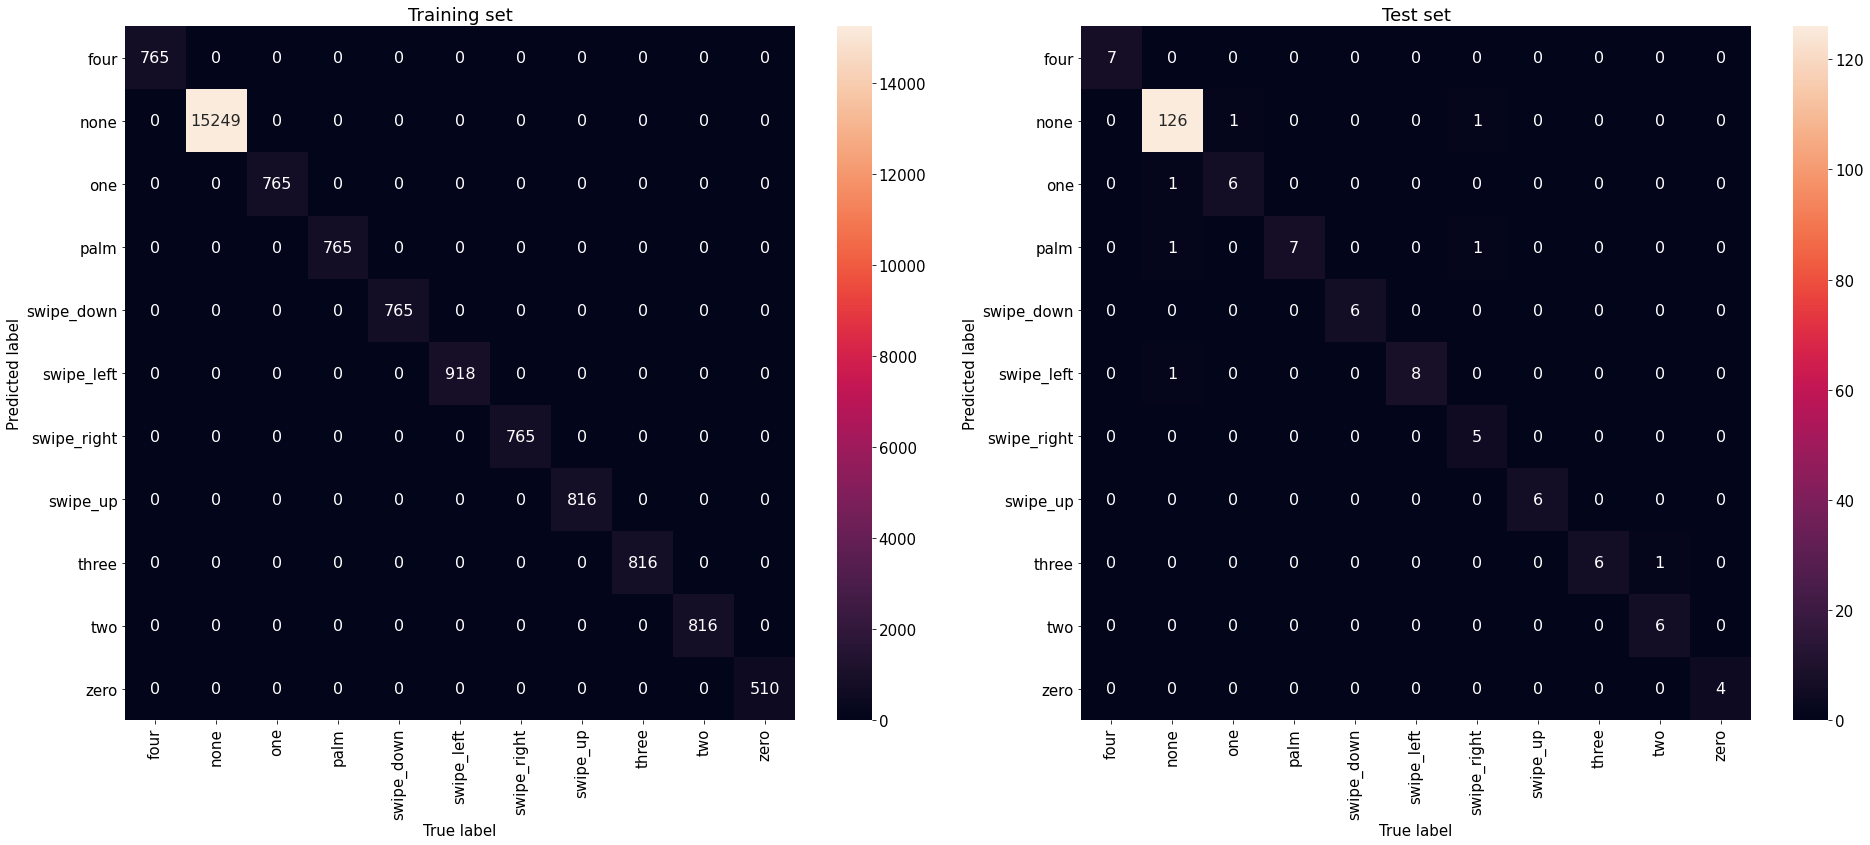

In [ ]:
#@title Plot Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig = plt.figure(figsize=(27, 12))

plt.subplot(1, 2, 1)
y_pred = lstm(X_train_augm)
y_pred_ord = np.argmax(y_pred, axis=1)
y_pred_ord = [labels[x] for x in y_pred_ord]
y_train_ord = np.argmax(y_train_augm, axis=1)
y_train_ord = [labels[x] for x in y_train_ord]
conf_matrix = confusion_matrix(y_pred_ord, y_train_ord)
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, annot_kws={"fontsize": 16}, fmt="g")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("Training set")

plt.subplot(1, 2, 2)
y_pred = lstm(X_valid)
y_pred_ord = np.argmax(y_pred, axis=1)
y_pred_ord = [labels[x] for x in y_pred_ord]
y_valid_ord = np.argmax(y_valid, axis=1)
y_valid_ord = [labels[x] for x in y_valid_ord]
conf_matrix = confusion_matrix(y_pred_ord, y_valid_ord)
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, annot_kws={"fontsize": 16}, fmt="g")
plt.title("Test set")
plt.xlabel("True label")
plt.ylabel("Predicted label")
# plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("confusion-matrix.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()


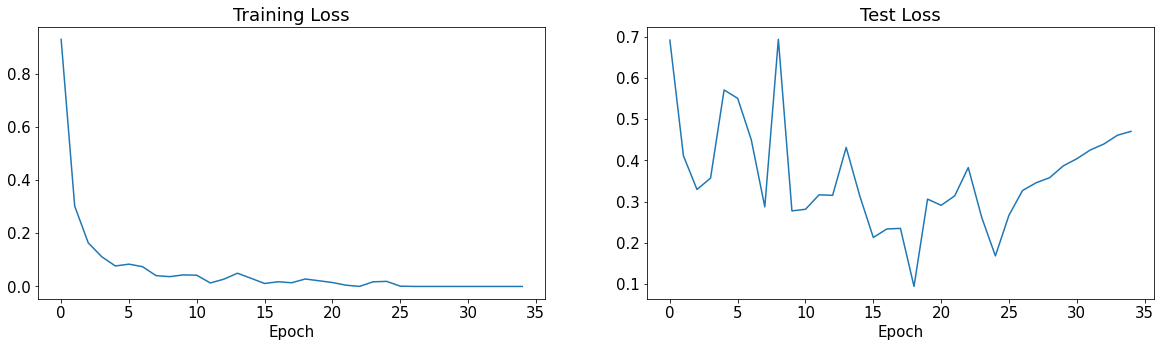

In [ ]:
#@title Plot Training Curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.plot(history.history["loss"])
plt.subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.savefig("losses.pdf", bbox_inches="tight")
plt.show()


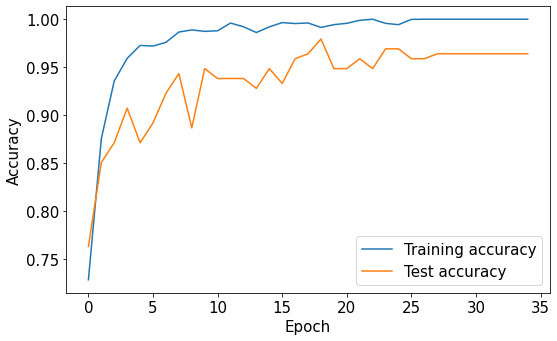

In [ ]:
#@title Plot Accuracy Curves
plt.figure(figsize=(8, 5))
train_acc =  history.history["categorical_accuracy"]
plt.plot(range(len(train_acc)), train_acc, label="Training accuracy")
val_acc = history.history["val_categorical_accuracy"]
plt.plot(range(len(val_acc)), val_acc, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy.pdf", bbox_inches="tight")
plt.tight_layout()
plt.show()

## Save model

In [ ]:
import json
with open("labels.json", "w", encoding="utf8") as f:
  json.dump(label_encoder.decoding, f)
print(label_encoder.decoding)

{0: 'four', 1: 'none', 2: 'one', 3: 'palm', 4: 'swipe_down', 5: 'swipe_left', 6: 'swipe_right', 7: 'swipe_up', 8: 'three', 9: 'two', 10: 'zero'}


In [ ]:
lstm.save("model.h5")

In [ ]:
# !copy /y labels.json "hands\labels.json"
# !copy /y model.h5 "hands\model.h5"

!copy /y labels.json "gesture-os\src\python\labels.json"
!copy /y model.h5 "gesture-os\src\python\model.h5"

        1 file copiati.
        1 file copiati.
